# Using Prexisting model

In [ ]:
#@title Imports
%%capture

!pip install imread
!pip install tifffile

import pandas   
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import os
import tqdm.notebook as tq
import PIL
import ipywidgets as widgets
from ipywidgets import interact
import imread
import cv2
import skimage.io as io


import argparse
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
sess = tf.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

#if tf.test.gpu_device_name():
#    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
#else:
#    print("no connection to gpu")

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, AveragePooling1D, Conv1D, LeakyReLU
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn import mixture

from keras.models import load_model




In [ ]:
## Install rsnapsim and its c++ package
!pip install biopython
!apt install libeigen3-dev
!ln -sf /usr/include/eigen3/Eigen /usr/include/Eigen
!pip install rsnapsim-ssa-cpp
!pip install rsnapsim

!pip install snapgene-reader
!pip install dna-features-viewer

     |████████████████████████████████| 2.3 MB 13.3 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libeigen3-doc libmrpt-dev
The following NEW packages will be installed:
  libeigen3-dev
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 810 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libeigen3-dev all 3.3.4-4 [810 kB]
Fetched 810 kB in 1s (1,280 kB/s)
Selecting previously unselected package libeigen3-dev.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../libeigen3-dev_3.3.4-4_all.deb ...
Unpacking libeigen3-dev (3.3.4-4) ...
Setting up libeigen3-dev (3.3.4-4) ...
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for rsnapsim-ssa-cpp: filename=rsna

In [ ]:
!pip install gdown
!gdown 'https://drive.google.com/uc?id=1ZhPvh2ZZTOy0wmHvHzlNcphFFvQ9-JmT'

Downloading...
From: https://drive.google.com/uc?id=1ZhPvh2ZZTOy0wmHvHzlNcphFFvQ9-JmT
To: /content/example_multiplexing_video.zip
100% 3.77G/3.77G [00:53<00:00, 70.6MB/s]


In [ ]:
!unzip /content/example_multiplexing_video.zip -d /content/

Archive:  /content/example_multiplexing_video.zip
  inflating: /content/cell_0.tif     
  inflating: /content/convae_ke_ki_5_7.h5  
  inflating: /content/convae_ke_ki_5_7_covariances.npy  
  inflating: /content/convae_ke_ki_5_7_means.npy  
  inflating: /content/convae_ke_ki_5_7_weights.npy  
  inflating: /content/sample_vid_df  


In [ ]:
# model files

h5_file = '/content/convae_ke_ki_5_7.h5'
means_file = '/content/convae_ke_ki_5_7_means.npy'
covar_file = '/content/convae_ke_ki_5_7_covariances.npy'
weights_file = '/content/convae_ke_ki_5_7_weights.npy'

In [ ]:
#@title Architechture CONV-AE + GMM of a similar condition

Nframes = 64
input_list = lambda strinput: [int(x) for x in strinput.split(',')]

def create_model(kernel_sizes, filter_sizes, pool_sizes):

    #encoding layers
    maxpooling=True
    strides = "1,1,1"
    total_encoding_layers = 2
    activation_function = 'tanh'
    w,h = Nframes,1
    center_layer_size = 2
    model = Sequential()
    model.add(keras.Input(shape=(w, 1))) # input layer

    for i in range(total_encoding_layers):
      pool_size = input_list(pool_sizes)[i]
      stride_size =  input_list(strides)[i]
      model.add(keras.layers.Conv1D(input_list(filter_sizes)[i], input_list(kernel_sizes)[i], stride_size, activation=activation_function,padding='same'))
      if maxpooling:
        model.add(keras.layers.MaxPooling1D(pool_size= pool_size))

    center_shape_in = (int(w/np.prod(input_list(pool_sizes ))) ,int(input_list(filter_sizes)[-1]))
    center_shape_flat = center_shape_in[0]*center_shape_in[1]
    
    ## center layers
    model.add(keras.layers.Flatten())
    model.add( keras.layers.Dense(center_layer_size, activation='tanh',))
    model.add( keras.layers.Dense(center_shape_flat, activation='tanh',))
    model.add(keras.layers.Reshape(center_shape_in ))
        
    
    ## decoding layers layers layers
    
    for i in range(total_encoding_layers-1,-1,-1):
      
      pool_size = input_list(pool_sizes)[i]
      stride_size =  input_list(strides)[i]
      model.add(keras.layers.Conv1D(input_list(filter_sizes)[i], input_list(kernel_sizes)[i], stride_size, activation=activation_function,padding='same'))
      if maxpooling:
        model.add(keras.layers.UpSampling1D(   pool_size ))
    
    model.add(keras.layers.Conv1D(1, input_list(kernel_sizes)[-1],  stride_size, activation=activation_function,padding='same'))
       

    model.compile(loss='MSE',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

filters= ["64,4",]
kernel_size = ["4,2"]
pools = ["4,2"]


class convAE:
  def __init__(self, DAE, gmm, sess):
    self.DAE = DAE
    self.gmm = gmm
    self.sess = sess

  def encode(self,x,center_layer=5):
    if len(x.shape) < 3:
      x = np.expand_dims(x,axis=-1)
    if x.dtype != np.float32:
      x = x.astype(np.float32)
    y = self.DAE.layers[0](x)
    for i in range(1,center_layer+1):
      y = self.DAE.layers[i](y)
    return y
  
  def predict(self,x):
    if len(x.shape) < 3:
      x = np.expand_dims(x,axis=-1)
    if x.dtype != np.float32:
      x = x.astype(np.float32)
    latents = self.sess.run(self.encode(x))
    return self.gmm.predict(latents)

  def predict_proba(self,x):
    if len(x.shape) < 3:
      x = np.expand_dims(x,axis=-1)
    if x.dtype != np.float32:
      x = x.astype(np.float32)
    latents = self.sess.run(self.encode(x))
    return self.gmm.predict_proba(latents)
    

  def visualize_latent_boundary(self):
    x = np.linspace(-2,2,200)
    y = np.linspace(-2,2,200)
    X,Y = np.meshgrid(x, y)

    Z = np.zeros([len(x)**2])
    k = 0
    for i in range(len(x)):
      for j in range(len(y)):
        Z[k] = self.gmm.predict( np.array( [[x[i], y[j]] ]))
        k+=1

    plt.imshow(Z.reshape(200,200))


## Load model + GMM model


#DAE = create_model(kernel_size[0], filters[0], pools[0])

DAE=load_model(h5_file)
means = np.load(means_file)
covar = np.load(covar_file)
gmm = mixture.GaussianMixture(n_components = len(means), covariance_type='full')
gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
gmm.weights_ = np.load(weights_file)
gmm.means_ = means
gmm.covariances_ = covar

cae = convAE(DAE,gmm,sess)


## load data

In [ ]:
data_file = '/content/sample_vid_df'
simulated_cell_dataframe = pandas.read_csv(data_file)

int_g_cell0 = simulated_cell_dataframe['green_int_mean'].values.reshape([5*50,3000])[:50,:]   
labels_cell0 = simulated_cell_dataframe['Classification'].values.reshape([5*50,3000])[:,0][:50]

x_cell0 = simulated_cell_dataframe['x'].values.reshape([5*50,3000])[:50,:]   
y_cell0 = simulated_cell_dataframe['y'].values.reshape([5*50,3000])[:50,:]   

def slice_arr(array, FR, Nframes,axis=1):
    total_time = FR*Nframes
    if total_time > 3000:
        print('WARNING: desired slicing regime is not possible, making as many frames as possible')
        return array[:,::FR]
    return array[:,::FR][:,:Nframes]

int_g_cell0_64 = slice_arr(int_g_cell0,5,64)
scaler = MinMaxScaler()
int_g_cell0_64_minmax = scaler.fit_transform(int_g_cell0_64)

predicted_labels_cell0 = cae.predict(int_g_cell0_64_minmax)
predicted_labels_cell0_proba = cae.predict_proba(int_g_cell0_64_minmax)

L = cae.encode(int_g_cell0_64_minmax)
latents = sess.run(L)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Log scale: values of z <= 0 have been masked
  


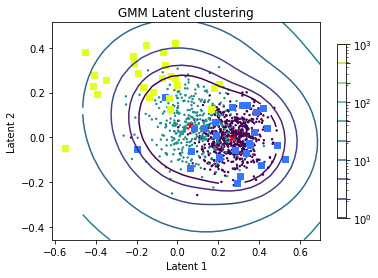

In [ ]:
from matplotlib.colors import LogNorm

xy,label = cae.gmm.sample(1000)
plt.scatter(*xy.T, c=cm.viridis(label*.5),alpha=1,s=2)

x = np.linspace(np.min(xy[:,0])-.2, np.max(xy[:,0])+.2,25)
y = np.linspace(np.min(xy[:,1])-.2, np.max(xy[:,1])+.2,25)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -cae.gmm.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(
    X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10)
)
CB = plt.colorbar(CS, shrink=0.8, extend="both")
#plt.scatter(X_train[:, 0], X_train[:, 1], 0.8)

plt.scatter(*cae.gmm.means_.T,marker='x',color='r')

c = ['#3675ff','#e5ff1c','#f54211']

colors = [c[int(labels_cell0[i])] for i in range(0,len(labels_cell0))]
plt.scatter(*latents.T, marker='s',color=colors)

plt.title('GMM Latent clustering')
plt.xlabel('Latent 1')
plt.ylabel('Latent 2')
plt.axis("tight")
plt.show()



## Cluster purity

In [ ]:
N = 10000
xy,label = cae.gmm.sample(N)

c1 = cae.gmm.predict(xy[label == 0])
c2 = cae.gmm.predict(xy[label == 1])
(np.sum(c1 == 0) + np.sum(c2 == 1) )/ N


0.8809

In [ ]:
centers = cae.gmm.means_

c1_dists = np.sqrt(np.sum(np.square(xy - centers[0,:]), axis=1))
c2_dists = np.sqrt(np.sum(np.square(xy - centers[1,:]), axis=1))
center_dist = np.sum(np.min(np.array([c1_dists,c2_dists]),axis=0))/ len(xy)
print(center_dist)


0.09844097202607645


In [ ]:
centers = cae.gmm.means_

c1_dists = np.sqrt(np.sum(np.square(latents - centers[0,:]), axis=1))
c2_dists = np.sqrt(np.sum(np.square(latents - centers[1,:]), axis=1))
center_dist = np.sum(np.min(np.array([c1_dists,c2_dists]),axis=0))/ len(latents)
print(center_dist)


0.2397986764766077


In [ ]:
print('Accuracy:')
print(1- np.sum(np.abs(predicted_labels_cell0 -labels_cell0))/ len(labels_cell0) )
print('----------------')
print('Average Incorrect confidence:')
av_conf_incorrect = np.mean(np.max(predicted_labels_cell0_proba[predicted_labels_cell0 - labels_cell0 == 1],axis=1))
print(av_conf_incorrect)
av_conf_correct = np.mean(np.max(predicted_labels_cell0_proba[predicted_labels_cell0 - labels_cell0 == 0],axis=1))
print('Average Correct confidence:')
print(av_conf_correct)





Accuracy:
0.88
----------------
Average Incorrect confidence:
0.8401074658326458
Average Correct confidence:
0.9547312750091771


In [ ]:
val_video = io.imread('/content/cell_0.tif')

val_video.shape


(3000, 512, 512, 3)

In [ ]:
plt.rcParams['figure.dpi'] = 140
plt.rcParams['grid.linewidth'] = .3
plt.rcParams['grid.linestyle'] = '--'



f = lambda frame: plt.imshow(  cv2.normalize( val_video[frame,:,:,1], dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX)   ,cmap=cm.Greens_r)
interact(f, frame=widgets.IntSlider(min=0, max=val_video.shape[0]-1, step=1, value=10));

interactive(children=(IntSlider(value=10, description='frame', max=2999), Output()), _dom_classes=('widget-int…

In [ ]:

def plot_frame_labeled(frame):
  if len(val_video) < 100:
    frames = [0,49,99,149,199]
  else:
    frames = list(range(0,3000))
  
  fig, axes = plt.subplots(1,2,dpi=200)

  vid_frame = cv2.normalize( val_video[frame,:,:,1], dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX)
  axes[0].imshow(vid_frame,cmap=cm.Greens_r)
  c = ['#3675ff','#e5ff1c','#f54211']

  colors = [c[int(predicted_labels_cell0[i])] for i in range(0,len(predicted_labels_cell0))]

  for i in range(len(colors)):
    if int(predicted_labels_cell0[i]) != int(labels_cell0[i]):
      colors[i] = 'r'

    if np.max(predicted_labels_cell0_proba[i,:]) < .75:
      colors[i] = 'k'


  axes[0].scatter(x_cell0[:,frame],y_cell0[:,frame],facecolors='none', edgecolors=colors, s=15)
  axes[0].set_title('Predicted labels')

  axes[1].imshow(vid_frame,cmap=cm.Greens_r)

  colors = [c[int(labels_cell0[i])] for i in range(0,len(labels_cell0))]

  
  axes[1].scatter(x_cell0[:,frame],y_cell0[:,frame],facecolors='none', edgecolors=colors, s=15)
  axes[1].set_title('True labels')
  percent_correct = np.sum(labels_cell0 == predicted_labels_cell0)/len(predicted_labels_cell0)
  axes[0].text(10,40,'Acc %1.4f '%percent_correct, color='white')




In [ ]:
f = lambda frame: plot_frame_labeled(frame)
interact(f, frame=widgets.IntSlider(min=0, max=val_video.shape[0]-1, step=1, value=10));

interactive(children=(IntSlider(value=10, description='frame', max=2999), Output()), _dom_classes=('widget-int…

In [ ]:
import matplotlib.animation as animation
from tqdm import tqdm_notebook

nf = 200
fig,ax  = plt.subplots(1,1,dpi=200)
c = ['#3675ff','#e5ff1c','#f54211']
colors = [c[int(predicted_labels_cell0[i])] for i in range(0,len(predicted_labels_cell0))]

for i in range(len(colors)):
  if int(predicted_labels_cell0[i]) != int(labels_cell0[i]):
    colors[i] = 'r'
  if np.max(predicted_labels_cell0_proba[i,:]) < .75:
    colors[i] = 'k'

#Define inital frames
vid_frame = cv2.normalize( val_video[0,:,:,1], dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX)
im = plt.imshow(vid_frame,cmap= 'Greens_r') # Reds_r
labels = ax.scatter(x_cell0[:,0],y_cell0[:,0],facecolors='none', edgecolors=colors, s=15)

percent_correct = np.sum(labels_cell0 == predicted_labels_cell0)/len(predicted_labels_cell0)
ax.text(10,40,'Acc %1.4f '%percent_correct, color='white')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=c[0], lw=2),
                Line2D([0], [0], color=c[1], lw=2),
                Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='k', lw=2)]
ax.legend(custom_lines, ['Spot type 1', 'Spot type 2', 'Incorrect', 'Uncertain'])

pbar = tqdm_notebook(total = nf)
#plt.axis('off')
def animate(i):
  vid_frame = cv2.normalize( val_video[i,:,:,1], dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX)
  

  im.set_array(vid_frame)
  labels.set_offsets(np.array([x_cell0[:,i],y_cell0[:,i]]).T )
  pbar.update(1)
  return im, labels

plt.close()
anim = animation.FuncAnimation(fig, animate, frames=nf, interval=150, blit=True)
#from IPython.display import HTML
#HTML(anim.to_html5_video())

anim.save('tmp.mp4')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/200 [00:00<?, ?it/s]

# Retrain only


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(int_g_cell0_64_minmax, labels_cell0, test_size=.2, random_state= 42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

DAE2 = create_model(kernel_size[0], filters[0], pools[0])
DAE2.fit(x = X_train, y=X_train, validation_data = (X_test,X_test) ,epochs=40,verbose=0 )

def encode(x,center_layer=5):
  y = DAE2.layers[0](x)
  for i in range(1,center_layer+1):
    y = DAE2.layers[i](y)
  return y

latents = sess.run(encode(X_train.astype(np.float32)))
latents_test = sess.run(encode(X_test.astype(np.float32)))
    
gmm2 = mixture.GaussianMixture(n_components=2,
                              covariance_type='full').fit(latents)

gmm_labels = gmm2.fit_predict(latents_test)  

cae2 = convAE(DAE2,gmm2,sess)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


In [ ]:
predicted_labels_cell0_retrain = cae2.predict(int_g_cell0_64_minmax)
predicted_labels_cell0_proba_retrain = cae2.predict_proba(int_g_cell0_64_minmax)

In [ ]:
predicted_labels_cell0_retrain = np.abs(1 - predicted_labels_cell0_retrain)

In [ ]:
print(np.sum(np.abs(labels_cell0 -   predicted_labels_cell0_retrain)))

array([[2.30968783e-03, 9.97690312e-01],
       [9.99678420e-01, 3.21580148e-04],
       [3.86742039e-07, 9.99999613e-01],
       [2.44056885e-06, 9.99997559e-01],
       [9.99429576e-01, 5.70424359e-04],
       [2.36696675e-12, 1.00000000e+00],
       [7.36776783e-01, 2.63223217e-01],
       [6.22676975e-02, 9.37732302e-01],
       [7.60512464e-01, 2.39487536e-01],
       [5.49146991e-07, 9.99999451e-01],
       [2.40149917e-05, 9.99975985e-01],
       [9.53997855e-03, 9.90460021e-01],
       [5.44204079e-07, 9.99999456e-01],
       [1.83489950e-05, 9.99981651e-01],
       [3.09739194e-07, 9.99999690e-01],
       [8.21883071e-08, 9.99999918e-01],
       [9.99995929e-01, 4.07120811e-06],
       [1.76179287e-06, 9.99998238e-01],
       [9.75364715e-10, 9.99999999e-01],
       [9.99999997e-01, 2.92996455e-09],
       [1.36434711e-05, 9.99986357e-01],
       [8.99488612e-04, 9.99100511e-01],
       [9.99980961e-01, 1.90387388e-05],
       [4.40758278e-11, 1.00000000e+00],
       [2.542720

In [ ]:
f = lambda frame: plot_frame_labeled(frame)
interact(f, frame=widgets.IntSlider(min=0, max=val_video.shape[0]-1, step=1, value=10));

interactive(children=(IntSlider(value=10, description='frame', max=2999), Output()), _dom_classes=('widget-int…

# Retrain + Fit

In [ ]:

import rsnapsim as rss

X_train, X_test, y_train, y_test = train_test_split(int_g_cell0_64_minmax, labels_cell0, test_size=.2, random_state= 42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

DAE2 = create_model(kernel_size[0], filters[0], pools[0])
DAE2.fit(x = X_train, y=X_train, validation_data = (X_test,X_test) ,epochs=40,verbose=0 )

def encode(x,center_layer=5):
  y = DAE2.layers[0](x)
  for i in range(1,center_layer+1):
    y = DAE2.layers[i](y)
  return y

latents = sess.run(encode(X_train.astype(np.float32)))
latents_test = sess.run(encode(X_test.astype(np.float32)))
#full_latents = sess.run(encode(int_g_cell0_64_minmax.astype(np.float32)))
    
gmm2 = mixture.GaussianMixture(n_components=2,
                              covariance_type='full').fit(latents)

#gmm_labels = gmm2.fit_predict(latents_test)  

cae2 = convAE(DAE2,gmm2,sess)
full_latents = cae2.encode(int_g_cell0_64_minmax)

#rss.solver.invert_ballistic( ,np.mean(spot_type_1_data))



/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


In [ ]:
latent_labels = cae2.predict(int_g_cell0_64_minmax)

spot_type_1_data = int_g_cell0_64_minmax[latent_labels == 0]
spot_type_2_data = int_g_cell0_64_minmax[latent_labels == 1]

acov_1,_ = rss.inta.get_autocov( np.expand_dims(spot_type_1_data.T, 0) , norm='ind')
acov_2,_ = rss.inta.get_autocov(np.expand_dims(spot_type_2_data.T, 0) , norm='ind')

acc_1,acc_error_1 = rss.inta.get_autocorr(acov_1,g0='G1' )
acc_2,acc_error_2 = rss.inta.get_autocorr(acov_2,g0='G1' )


80 60


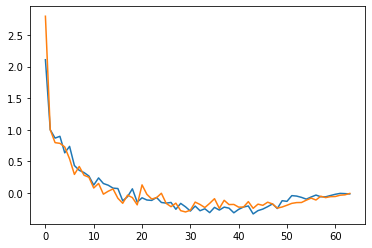

In [ ]:
plt.plot(np.mean(acc_1[0],axis=1))
plt.plot(np.mean(acc_2[0],axis=1))

tau1 = np.where(np.mean(acc_1[0],axis=1) < 0)[0][0]*5
tau2 = np.where(np.mean(acc_2[0],axis=1) < 0)[0][0]*5
print(tau1,tau2)

In [ ]:
kdm5b_L = 4647/3
p300_L = 7257/3
Lt = 1011/3
Lm = 505/3
n_epitopes = 10

ke1 = p300_L / (tau1*5)
ke2 = kdm5b_L / (tau2*5)

print(ke1,ke2)

ki1 = (np.mean(int_g_cell0_64[latent_labels == 0]) /Lt) / ( (1.-Lm/float(p300_L))*tau1)
ki2 = (np.mean(int_g_cell0_64[latent_labels == 1]) /Lt) / ( (1.-Lm/float(kdm5b_L))*tau2)

print(ki1,ki2)

6.0475 5.163333333333333
0.05420638787340103 0.11159009791582043


0.6258382192908377